## DDrad sequencing

In this project we try to implement DDrad sequencing. In order to eliminate the cost of sequencing we utilize restriction enzymes. Those enzymes cut the dna sequence in specific fragments related to their site and we end up with subsequences having significant smaller length than the original dna sequence. 
Furthermore, we analyse the SNPs on those fragments trying to investigate which couple of restriction enzymes is giving the largest fragments with the maximum number of SNPs.

In [371]:
# For analysis purpose we use the restriction enzyme package from Bio.Restriction
#
# load libraries

import pandas as pd
from Bio import SeqIO, Restriction
from Bio.SeqUtils import nt_search
from Bio.Seq import Seq
import os
import sys
import seaborn as sn

In [202]:
# Load information about restriction enzymes
renAll = Restriction.AllEnzymes

Here are the attributes of AllEnzymes

'add',
 'add_nocheck',
 'add_supplier',
 'already_mapped',
 'as_string',
 'clear',
 'copy',
 'current_suppliers',
 'difference',
 'difference_update',
 'discard',
 'elements',
 'format',
 'get',
 'intersection',
 'intersection_update',
 'is_restriction',
 'isdisjoint',
 'issubset',
 'issuperset',
 'lambdasplit',
 'mapping',
 'pop',
 'remove',
 'search',
 'show_codes',
 'split',
 'suppl_codes',
 'suppliers',
 'symmetric_difference',
 'symmetric_difference_update',
 'union',
 'update'
 

In [203]:
#number of restriction enzymes
print("Restriction enzymes are",len(renAll.elements()))
for e in renAll.elements()[:10]:
    print(e, end = " ")
print(" and so on...")

Restriction enzymes are 1065
AanI AarI AasI AatII Aba13301I Aba6411II AbaB8342IV AbaCIII AbaPBA3II AbaSI  and so on...


In [204]:
#attributes of enzyme class
for at in dir(renAll.get("BcoDI"))[59:]:
    print(at, end = "   ")

all_suppliers   buffers   catalyse   catalyze   charac   characteristic   compatible_end   compsite   cut_once   cut_twice   dna   elucidate   equischizomers   freq   frequency   fst3   fst5   id   inact_temp   is_3overhang   is_5overhang   is_ambiguous   is_blunt   is_comm   is_defined   is_equischizomer   is_isoschizomer   is_methylable   is_neoschizomer   is_palindromic   is_unknown   isoschizomers   mro   neoschizomers   opt_temp   overhang   ovhg   ovhgseq   results   scd3   scd5   search   site   size   substrat   suppl   supplier_list   suppliers   uri   

In [206]:
# Read additional information about restriction enzymes from xlsx file
infofile = pd.read_csv("/home/loukas/Documents/bioinformatics/ddrad RE double digest.xlsx - RE characteristics.tsv", sep="\t")
infofile

,RE,recognition site /cut,Palindromic enzymes,recognition size,recognition site uniqness,conflicts,activity temperature,% Activity in NEBuffer
0,AatII,GACGT/C,Yes,6,unique,NaN,37.0,rCutSmart Buffer
1,Acc65I,G/GTACC,Yes,6,same as KpnI,Kpnl,37.0,NEBuffer r3.1
2,AccI,GT/MKAC,No,NaN,NaN,NaN,NaN,NaN
3,AciI,CCGC(-3/-1),No,NaN,NaN,NaN,NaN,NaN
4,AclI,AA/CGTT,Yes,6,unique,NaN,37.0,rCutSmart Buffer
...,...,...,...,...,...,...,...,...
219,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
220,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
221,NaN,NaN,NaN,frequent,NaN,NaN,NaN,NaN
222,NaN,NaN,NaN,medium,NaN,NaN,NaN,NaN


In [207]:
infofile.columns

Index(['RE', 'recognition site /cut', 'Palindromic enzymes',
       'recognition size', 'recognition site uniqness', 'conflicts',
       'activity temperature', '% Activity in NEBuffer'],
      dtype='object')

In [208]:
palindromic_indexes = infofile["Palindromic enzymes"] == "Yes"

# Select palindromic enzymes
restr = infofile.loc[palindromic_indexes, "RE"]

print("These are the {} palindromic enzymes\n".format(len(restr)))
for e in restr:
    print(e, end="  ")

These are the 64 palindromic enzymes

AatII  Acc65I  AclI  AflII  AgeI  ApaI  ApaLI  AscI  AseI  AsiSI  AvrII  BamHI  BclI  BfaI  BfuCI  BglII  BmtI  BsiWI  BspDI  BspEI  BspHI  BsrGI  BssHII  BstBI  CviAII  CviQI  EagI  EcoRI  FatI  FseI  HhaI  HindIII  HinP1I  HpaI  HpyCH4IV  KasI  KpnI  MluCI  MluI  MseI  NarI  NcoI  NdeI  NgoMIV  NheI  NlaIII  NotI  NsiI  PacI  PaeR7I  PciI  PluTI  PspOMI  PstI  PvuI  SacI  SacII  SalI  SbfI  SpeI  SphI  TaqaI  TspMI  XbaI  

In [209]:
# Extract recognition sites of palindromic enzymes
restrsites = infofile.loc[palindromic_indexes, "recognition site /cut"]
restrsites = restrsites.str.replace("/", "")
restrsites = pd.Series(restrsites.values, index=infofile.loc[palindromic_indexes, "RE"]); restrsites

RE
AatII     GACGTC
Acc65I    GGTACC
AclI      AACGTT
AflII     CTTAAG
AgeI      ACCGGT
           ...  
SpeI      ACTAGT
SphI      GCATGC
TaqaI       TCGA
TspMI     CCCGGG
XbaI      TCTAGA
Length: 64, dtype: object

In [210]:
# Keep all the palindromic enzymes in RestrictionBatch class

from Bio.Restriction import *

renz = RestrictionBatch([])

for i in restr.index:
    print(i, restr[i], end="  ")
    if i not in [39,205]:
        renz.add(restr[i])

print("\n\nThere are {} palindromic restriction enzymes".format(len(renz)))

0 AatII  1 Acc65I  4 AclI  7 AflII  9 AgeI  15 ApaI  16 ApaLI  19 AscI  20 AseI  21 AsiSI  24 AvrII  26 BamHI  35 BclI  37 BfaI  39 BfuCI  41 BglII  45 BmtI  60 BsiWI  67 BspDI  68 BspEI  69 BspHI  74 BsrGI  76 BssHII  80 BstBI  94 CviAII  96 CviQI  102 EagI  109 EcoRI  111 FatI  115 FseI  120 HhaI  122 HindIII  124 HinP1I  125 HpaI  133 HpyCH4IV  135 KasI  136 KpnI  139 MluCI  140 MluI  145 MseI  150 NarI  152 NcoI  153 NdeI  154 NgoMIV  155 NheI  156 NlaIII  159 NotI  161 NsiI  164 PacI  165 PaeR7I  166 PciI  169 PluTI  176 PspOMI  178 PstI  179 PvuI  183 SacI  184 SacII  185 SalI  187 SbfI  199 SpeI  200 SphI  205 TaqaI  208 TspMI  210 XbaI  

There are 62 palindromic restriction enzymes


In [283]:
# Categorize recognition sites into "frequent" if len ==4 otherwise "rare" 
frequent = RestrictionBatch([])
rare = RestrictionBatch([])

for e in renz:
    if e.size == 4:
        frequent.add(e)
    else:
        rare.add(e)

print("Enzymes frequent : {} \n{}".format(len(frequent),frequent))
print("\nEnzymes rare : {} \n{}".format(len(rare),rare))

Enzymes frequent : 10 
BfaI+CviAII...MseI+NlaIII

Enzymes rare : 52 
AatII+Acc65I...TspMI+XbaI


In [314]:
# Load 19 chromosomes of Vitis Vinifera
file = "/home/loukas/Documents/bioinformatics/Vitis_vinifera.fa.gz"
seqs = list(SeqIO.parse(file, "fasta"))

for s in seqs:
    print("Chromosome {}, size {}".format(s.id,sys.getsizeof(s)))

print("\nTotal size:",sys.getsizeof(seqs))

Chromosme 10, size 48
Chromosme 11, size 48
Chromosme 12, size 48
Chromosme 13, size 48
Chromosme 14, size 48
Chromosme 15, size 48
Chromosme 16, size 48
Chromosme 17, size 48
Chromosme 18, size 48
Chromosme 19, size 48
Chromosme 1, size 48
Chromosme 2, size 48
Chromosme 3, size 48
Chromosme 4, size 48
Chromosme 5, size 48
Chromosme 6, size 48
Chromosme 7, size 48
Chromosme 8, size 48
Chromosme 9, size 48

Total size: 248


In [18]:
# attributes and methods for dna sequence
for at in dir(seqs[0])[38:]:
    print(at,end="  ")

annotations  count  dbxrefs  description  features  format  id  islower  isupper  letter_annotations  lower  name  reverse_complement  seq  translate  upper  

In [212]:
# fcut the chromosome with a pair of enzymes
# returns the positions of the double digest fragments

def double_digest(chromosome,enz1, enz2):
    enzpos1 = enz1.search(chromosome.seq)
    enzpos2 = enz2.search(chromosome.seq)
    ddpos = []; start = []; end = []
    i=0; j=0
    
    if enzpos1[0] < enzpos2[0]:
        start = enzpos1
        end = enzpos2
    else:
        start = enzpos2
        end = enzpos1

    while i < len(start) and j < len(end):
        while i < len(start) and start[i] <= end[j]:
            i+=1
        
        if i == len(start):
            ddpos.append(start[i-1])
            ddpos.append(end[j])
            return ddpos
        
        ddpos.append(start[i-1])
        ddpos.append(end[j])
        
        while  j < len(end) and  end[j] <= start[i]:
            j+=1
        
        if j == len(end):
            ddpos.append(end[j-1])
            ddpos.append(start[i])
            return ddpos
        
        ddpos.append(end[j-1])
        ddpos.append(start[i])
        
    return ddpos


We cut each chromosome with all the possible couples of restriction enzymes and store them to fasta file

In [338]:

def ddcut():
    os.chdir("/home/loukas/Documents/bioinformatics")

    for ch_num in range(1,len(seqs)):
        ch = seqs[ch_num]
        path = "chromosome" + str(ch.id)
        os.mkdir(path)
        os.chdir(path)
        for i in range(len(renz.elements()) - 1):
            e1 = renz.get(renz.elements()[i])
            for j in range(i+1, len(renz.elements())):
                e2 = renz.get(renz.elements()[j])
                dd = double_digest(ch,e1,e2)

                #write to file
                filename = "chromosome" + ch.id + str(e1) + str(e2) + ".fasta"
                with open(filename, "w") as file1:
                    for k in range(0,len(dd),2):
                        file1.write(" ".join([">", str(e1), str(e2), str(k), "chromosome_id", ch.id, "length", str(len(ch.seq[dd[k]:dd[k+1]])), "\n"]))
                        file1.write(str(ch.seq[dd[k]-1:dd[k+1]-1]) + "\n")

        os.chdir("/home/loukas/Documents/bioinformatics")

#ddcut()

In [339]:
# function that yields every line in fasta file without storing in RAM
import os
import os.path

def read_fasta(chromosome, enz1,enz2):
    os.chdir("/home/loukas/Documents/bioinformatics/chromosome"+str(chromosome.id))
    
    filename = "chromosome"+str(chromosome.id)+str(enz1)+str(enz2)+".fasta"
    
    if os.path.exists(filename)==False:
        filename = "chromosome"+str(chromosome.id)+str(enz2)+str(enz1)+".fasta"
    
    with open(filename, "r") as handle:
        for line in handle:
            yield line

In [446]:
# matrices for stats

resMat = pd.DataFrame(0, index=renz.elements(), columns=renz.elements())

# number of fragments for each couple
resMatNumFrag = resMat.copy()
# summation of cut lengths for each combination
resMatLengths = resMat.copy()
# mean length values foreach combination and frequent/rare value
resMeanLengths = pd.DataFrame(index = resMat.index, columns=["MeanLength","std","frequent"])
# length fragments for each couple
resMatDistr = pd.DataFrame(list(), index=renz.elements(), columns=renz.elements())

In [447]:
# read the .fasta file from chromosome

def build_matrices(chrom_num):
    os.chdir("/home/loukas/Documents/bioinformatics/")
    ch = seqs[chrom_num]
    mnl = []
    std = []
    frq = []

    for i in range(len(renz.elements())):
        e1 = renz.elements()[i]
        for j in range(len(renz.elements())):
            e2 = renz.elements()[j]
            num_frag = 0
            len_frag = []
            if e1 != e2:
                for l in read_fasta(ch,e1,e2):
                    if l[0]==">":
                        num_frag += 1
                        len_frag.append(int(l.split()[-1]))
                resMatNumFrag.loc[e1,e2] = num_frag
                resMatLengths.loc[e1,e2] = sum(len_frag)
                resMatDistr.loc[e1,e2] = len_frag
            else:
                continue
                
    
    for e in resMatLengths.columns:
            mnl.append(resMatLengths[e].mean())
            std.append(resMatLengths[3].std())

            if len(renz.get(e).site)==4:
                frq.append("freq")
            else:
                frq.append("rare")

    resMeanLengths["MeanLength"] = mnl
    resMeanLengths["std"] = std
    resMeanLengths["frequent"] = frq


build_matrices(chrom_num=1)

In [448]:
resMatLengths

,AatII,Acc65I,AclI,AflII,AgeI,ApaI,ApaLI,AscI,AseI,AsiSI,...,PstI,PvuI,SacI,SacII,SalI,SbfI,SpeI,SphI,TspMI,XbaI
AatII,0,7950605,8599323,3884376,8397681,8634859,6749776,1050685,2021300,523058,...,6873157,10386948,5988302,7144123,9942888,3781156,5199449,5308939,9253844,3803564
Acc65I,7950605,0,9866228,6941165,9480861,9336168,9302789,501436,4061225,303518,...,9092616,7710508,8850214,4051140,8596471,2031485,8228446,8690301,6994548,7126284
AclI,8599323,9866228,0,6601748,9413856,9807888,8595784,530420,3203634,334939,...,9149744,8017637,8964970,4454582,8270789,2379441,7629474,7909952,7383952,6357654
AflII,3884376,6941165,6601748,0,5850232,6291720,8561075,195446,7369089,89677,...,7784887,3551505,8608438,1824000,4524067,861790,9387651,9055022,3147322,9667897
AgeI,8397681,9480861,9413856,5850232,0,9368764,8338595,905828,3123722,334975,...,8135466,8765651,7785812,5620427,8964791,2915095,6706213,7765547,7934400,5667103
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SbfI,3781156,2031485,2379441,861790,2915095,2424483,1736761,7021184,316788,4403194,...,629424,4376323,1225973,8288875,3620222,0,1160945,1252676,5645907,809011
SpeI,5199449,8228446,7629474,9387651,6706213,7479940,9308676,230725,6581446,141446,...,8495732,4599858,9405279,2360518,5502894,1160945,0,9705589,3836382,9546507
SphI,5308939,8690301,7909952,9055022,7765547,7959393,9726253,207442,6053979,119088,...,8962473,5087074,9940385,2571834,5934295,1252676,9705589,0,4336084,8809339
TspMI,9253844,6994548,7383952,3147322,7934400,7199418,5255028,1929589,1490021,912880,...,5498819,9868708,4669994,8486353,9526295,5645907,3836382,4336084,0,3039485


In [449]:
resMatNumFrag

,AatII,Acc65I,AclI,AflII,AgeI,ApaI,ApaLI,AscI,AseI,AsiSI,...,PstI,PvuI,SacI,SacII,SalI,SbfI,SpeI,SphI,TspMI,XbaI
AatII,0,922,873,1117,808,891,1011,42,1212,21,...,1002,637,1081,321,713,149,1062,1040,539,1153
Acc65I,922,0,1444,2421,1399,1402,1949,42,2829,22,...,1851,889,1998,378,1062,175,2214,2155,703,2443
AclI,873,1444,0,2054,1165,1320,1634,40,2438,22,...,1638,797,1769,362,925,173,1936,1814,659,2103
AflII,1117,2421,2054,0,1865,2072,3346,42,7700,22,...,3022,1055,3520,408,1331,184,4532,3947,801,5405
AgeI,808,1399,1165,1865,0,1172,1681,42,2143,22,...,1413,881,1625,368,1022,167,1832,1735,617,1901
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SbfI,149,175,173,184,167,173,182,36,184,18,...,180,154,171,123,159,0,180,178,156,184
SpeI,1062,2214,1936,4532,1832,1864,3043,42,6011,22,...,2682,1089,3078,406,1268,180,0,3484,786,4585
SphI,1040,2155,1814,3947,1735,1832,2871,42,5145,22,...,2695,999,2970,404,1216,178,3484,0,779,3951
TspMI,539,703,659,801,617,697,752,42,852,20,...,743,518,775,300,581,156,786,779,0,804


In [468]:
resMatDistr = resMatDistr.fillna(0)
resMatDistr.iloc[:5,:10]

,AatII,Acc65I,AclI,AflII,AgeI,ApaI,ApaLI,AscI,AseI,AsiSI
AatII,0,"[1893, 1885, 2787, 1196, 20916, 12970, 35915, ...","[11917, 26346, 18203, 3812, 1659, 5199, 11388,...","[2472, 2480, 6139, 350, 920, 3924, 367, 4375, ...","[4134, 3866, 2376, 3773, 18319, 5209, 2493, 33...","[20092, 27109, 18719, 3393, 8792, 4202, 21, 12...","[198, 206, 14312, 2244, 15243, 6869, 11547, 87...","[4688, 15248, 230, 104090, 2613, 43578, 6471, ...","[1016, 1178, 1184, 1010, 217, 2394, 944, 2635,...","[33584, 14113, 21735, 20867, 20897, 39948, 770..."
Acc65I,"[1893, 1885, 2787, 1196, 20916, 12970, 35915, ...",0,"[5804, 15929, 7266, 7580, 17007, 4688, 13007, ...","[4365, 4365, 26, 180, 4404, 4866, 311, 1458, 2...","[2241, 1981, 2247, 11547, 3299, 411, 3572, 257...","[13979, 550, 6503, 8343, 17523, 4178, 26931, 1...","[2091, 2091, 8199, 2730, 772, 2049, 467, 10499...","[11932, 4206, 10934, 3362, 568, 28182, 9549, 3...","[193, 191, 3995, 85, 1000, 325, 67, 4367, 227,...","[5999, 1406, 112, 3020, 31124, 10195, 1658, 82..."
AclI,"[11917, 26346, 18203, 3812, 1659, 5199, 11388,...","[5804, 15929, 7266, 7580, 17007, 4688, 13007, ...",0,"[1994, 6953, 193, 2714, 15, 4179, 1292, 1293, ...","[8051, 4281, 14410, 105, 3073, 3587, 5317, 270...","[2941, 763, 419, 5052, 510, 17185, 29098, 3785...","[12123, 2395, 746, 1026, 1067, 4592, 6494, 553...","[13470, 15299, 9312, 24202, 282, 1477, 12333, ...","[1419, 1126, 2015, 1877, 3744, 2932, 198, 92, ...","[713, 7851, 77492, 13449, 2526, 7967, 17643, 2..."
AflII,"[2472, 2480, 6139, 350, 920, 3924, 367, 4375, ...","[4365, 4365, 26, 180, 4404, 4866, 311, 1458, 2...","[1994, 6953, 193, 2714, 15, 4179, 1292, 1293, ...",0,"[6606, 6346, 2273, 1567, 4762, 1869, 2026, 374...","[10169, 254, 640, 370, 861, 570, 531, 3760, 31...","[2274, 2274, 6345, 4389, 2361, 250, 1530, 361,...","[14382, 4448, 14701, 692, 160, 760, 4905, 3247...","[75, 835, 456, 77, 111, 974, 359, 398, 254, 11...","[3869, 284, 1728, 1726, 796, 2815, 8738, 2550,..."
AgeI,"[4134, 3866, 2376, 3773, 18319, 5209, 2493, 33...","[2241, 1981, 2247, 11547, 3299, 411, 3572, 257...","[8051, 4281, 14410, 105, 3073, 3587, 5317, 270...","[6606, 6346, 2273, 1567, 4762, 1869, 2026, 374...",0,"[16226, 5044, 14926, 8602, 3583, 20772, 1532, ...","[4332, 4072, 10446, 10775, 1250, 10910, 132, 6...","[21856, 7, 13412, 20293, 4687, 7023, 17227, 19...","[2434, 2172, 2014, 1068, 4678, 254, 1926, 1379...","[13018, 1414, 8297, 156, 5270, 1491, 16027, 25..."


In [451]:
resMeanLengths = resMeanLengths.sort_values(by="frequent")
resMeanLengths

,MeanLength,frequent
HinP1I,5.568257e+06,freq
HhaI,5.581238e+06,freq
MluCI,1.362704e+06,freq
FatI,2.206177e+06,freq
MseI,1.585639e+06,freq
...,...,...
EcoRI,5.551691e+06,rare
FseI,1.325502e+06,rare
TspMI,4.759441e+06,rare
HpaI,6.126494e+06,rare


In [458]:
# find enzymes with 200 < fragment < 600 ------ let's call it fine cut!

def fineCut(dataframe):
    
    d = pd.DataFrame(0, index = dataframe.index, columns = dataframe.columns)
    
    for i in range(len(dataframe.index)):
        for j in range(len(dataframe.columns)):
            if dataframe.loc[dataframe.index[i],dataframe.columns[j]] != 0:
                count=0
                for l in dataframe.loc[dataframe.index[i],dataframe.columns[j]]:
                    if l >=200 and l <=600:
                        count+=1
                d.loc[dataframe.index[i],dataframe.columns[j]] = count
    
    return d
    
finecut = fineCut(resMatDistr)
finecut

,AatII,Acc65I,AclI,AflII,AgeI,ApaI,ApaLI,AscI,AseI,AsiSI,...,PstI,PvuI,SacI,SacII,SalI,SbfI,SpeI,SphI,TspMI,XbaI
AatII,0,44,40,117,43,53,68,3,251,1,...,90,22,91,18,31,6,70,69,21,121
Acc65I,44,0,90,339,59,89,199,4,637,0,...,163,49,171,9,48,6,209,222,33,285
AclI,40,90,0,224,69,78,119,6,586,0,...,119,42,139,11,53,4,178,150,19,247
AflII,117,339,224,0,239,251,468,1,2082,2,...,406,151,567,32,188,16,920,630,54,1091
AgeI,43,59,69,239,0,50,163,0,555,0,...,107,42,170,13,48,5,277,127,24,290
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SbfI,6,6,4,16,5,5,8,1,32,0,...,6,2,11,0,7,0,17,11,0,13
SpeI,70,209,178,920,277,149,355,2,1658,1,...,316,86,375,28,97,17,0,406,43,741
SphI,69,222,150,630,127,164,311,4,1282,0,...,342,85,322,26,80,11,406,0,68,608
TspMI,21,33,19,54,24,40,51,1,146,2,...,49,12,49,15,22,0,43,68,0,78


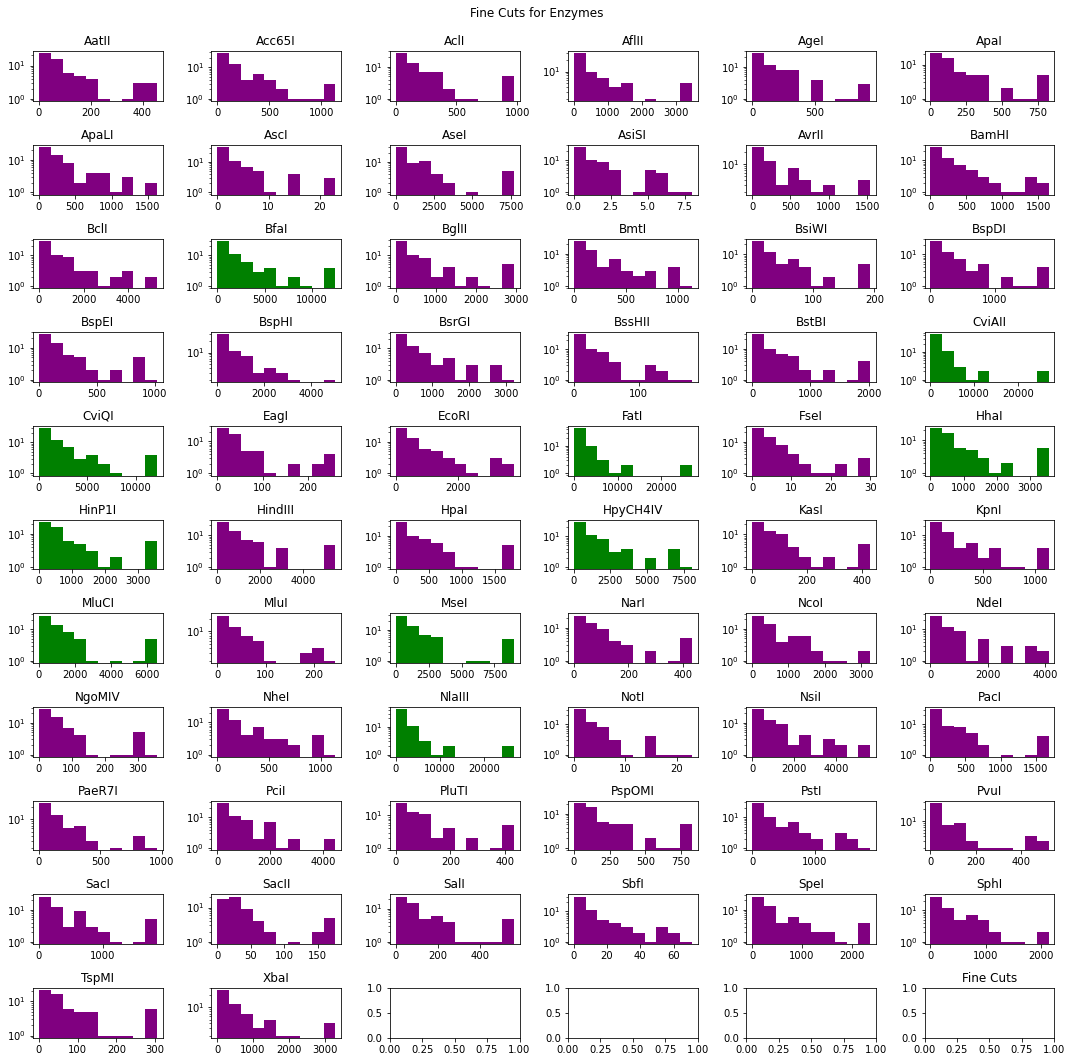

In [455]:
# histogram for fine cuts
rareFreqColor = {}
for e in resMeanLengths.index:
    rareFreqColor[e] = resMeanLengths.loc[e,"frequent"]
    
colors = ["green"  if rareFreqColor[v]=="freq" else "purple" for v in finecut.index]


# Create subplots with specified colors
fig, axes = pl.subplots(11, 6, figsize=(15, 15), tight_layout=True)

k=0
for i in range(11):
    for j in range(6):
        col = finecut.columns[k]
        axes[i,j].hist(finecut[col], bins=10, color=colors[k], log=True)
        axes[i,j].set_title(f'{col}')
        k+=1
        if k == len(finecut.columns):
            break

pl.suptitle('Fine Cuts for Enzymes\n')
pl.tight_layout()
pl.title("Fine Cuts")
pl.savefig("/home/loukas/Documents/bioinformatics/fineCutsHist.pdf",format="pdf",dpi=100,orientation='portrait')
pl.show()


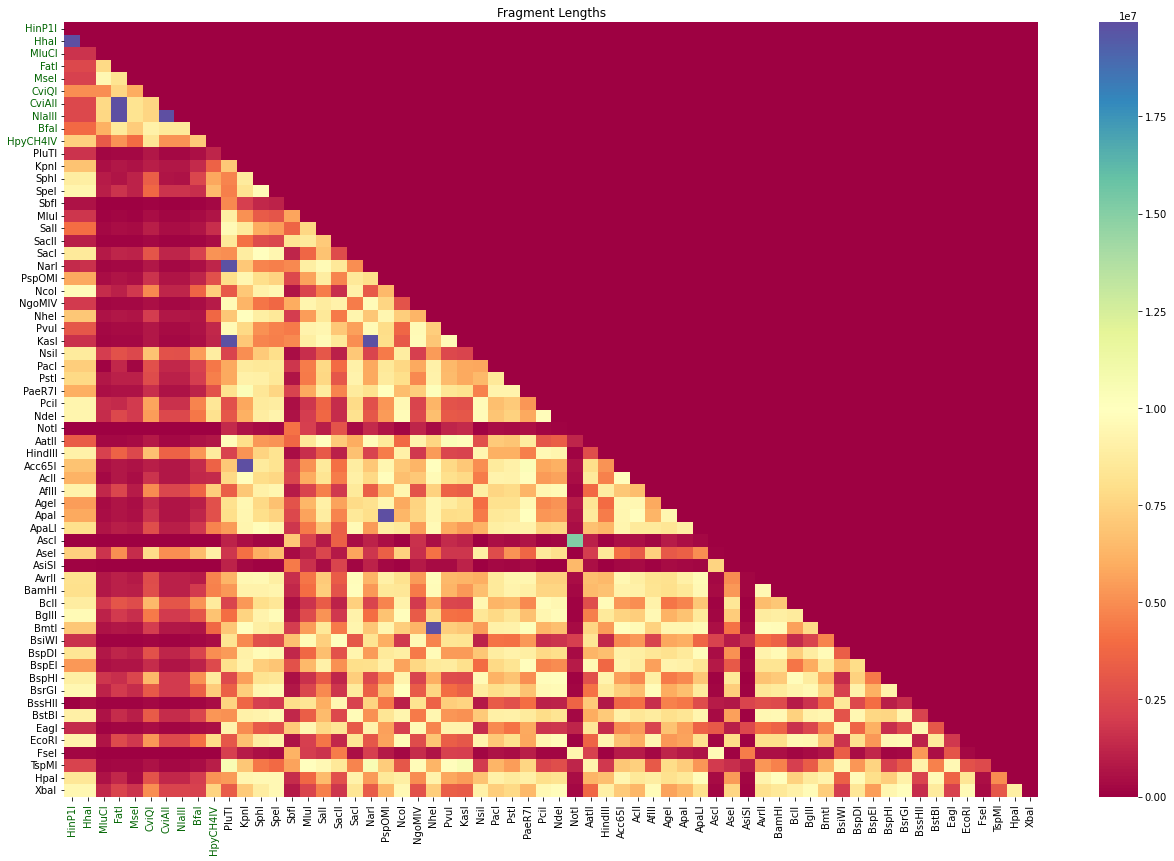

In [456]:

#sort lengths matrix by rare/freq
resMatLengths = resMatLengths.reindex(resMeanLengths.index)
resMatLengths = resMatLengths[resMeanLengths.index]
lengthsSimple = resMatLengths.copy()

for i in range(len(lengthsSimple.index)-1):
    for j in range(i+1,len(lengthsSimple.index)):
        lengthsSimple.iloc[i,j] = 0

def heatmap_(dataframe,fname):
    pl.figure(figsize=(18,12))
    hm = sn.heatmap(dataframe, cmap="Spectral",xticklabels="auto", yticklabels="auto",linewidths=0)
    for lb in hm.get_xticklabels():
        if resMeanLengths.loc[lb.get_text(),"frequent"]=="freq":
            lb.set_color("darkgreen")
    for lb in hm.get_yticklabels():
        if resMeanLengths.loc[lb.get_text(),"frequent"]=="freq":
            lb.set_color("darkgreen")

    pl.tight_layout()
    pl.title("Fragment Lengths\n")
    pl.savefig("/home/loukas/Documents/bioinformatics/"+fname+".pdf",format="pdf",dpi=100,orientation='portrait')

heatmap_(lengthsSimple,"fraglen")

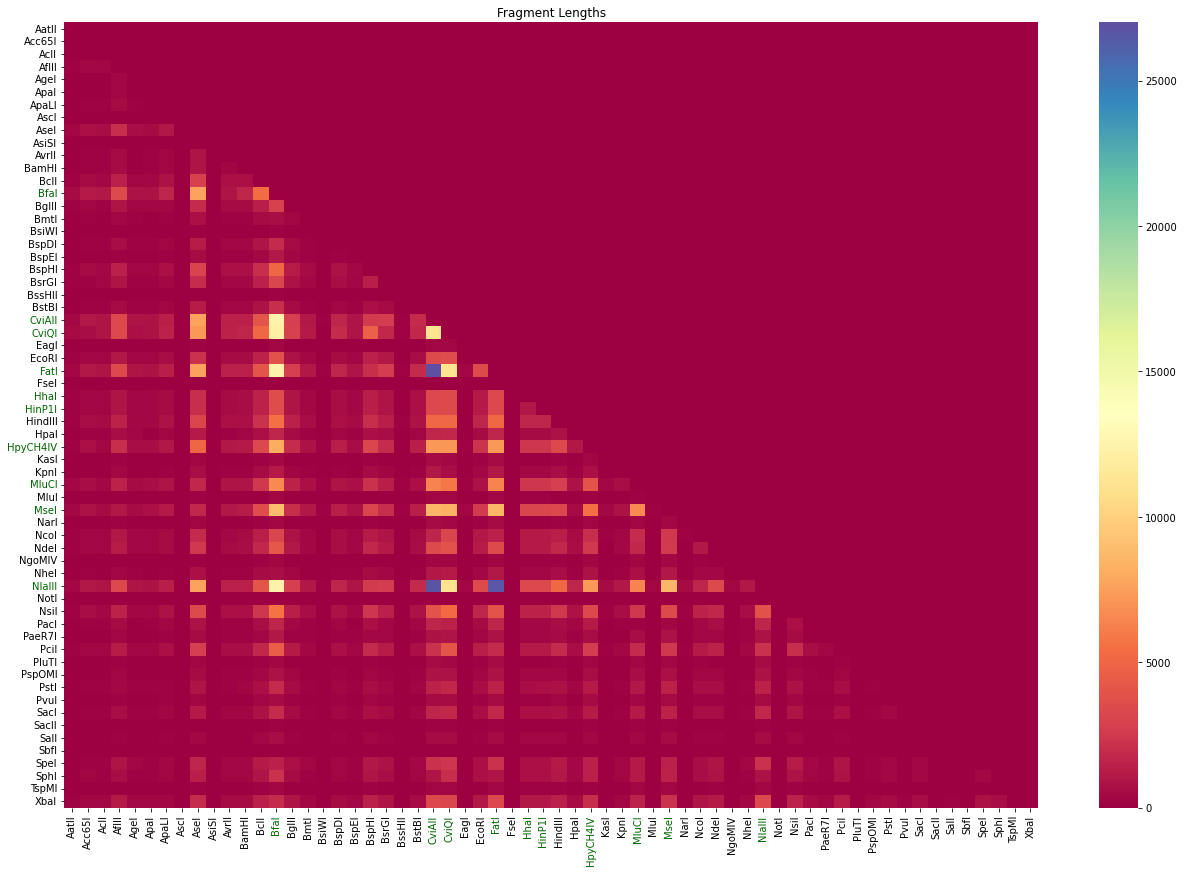

In [460]:
# finecut with zeroes above diagonial

finecutSimple = finecut.copy()

for i in range(len(finecut.index)):
    for j in range(i,len(finecut.columns)):
        finecutSimple.iloc[i,j] = 0
        
heatmap_(finecutSimple,"frag200_600")

In [ ]:
# Top-10 enzymes with the largest cuts




Observing from another perspective, if we sort the resMatLengths by column we could see areas of high and low density

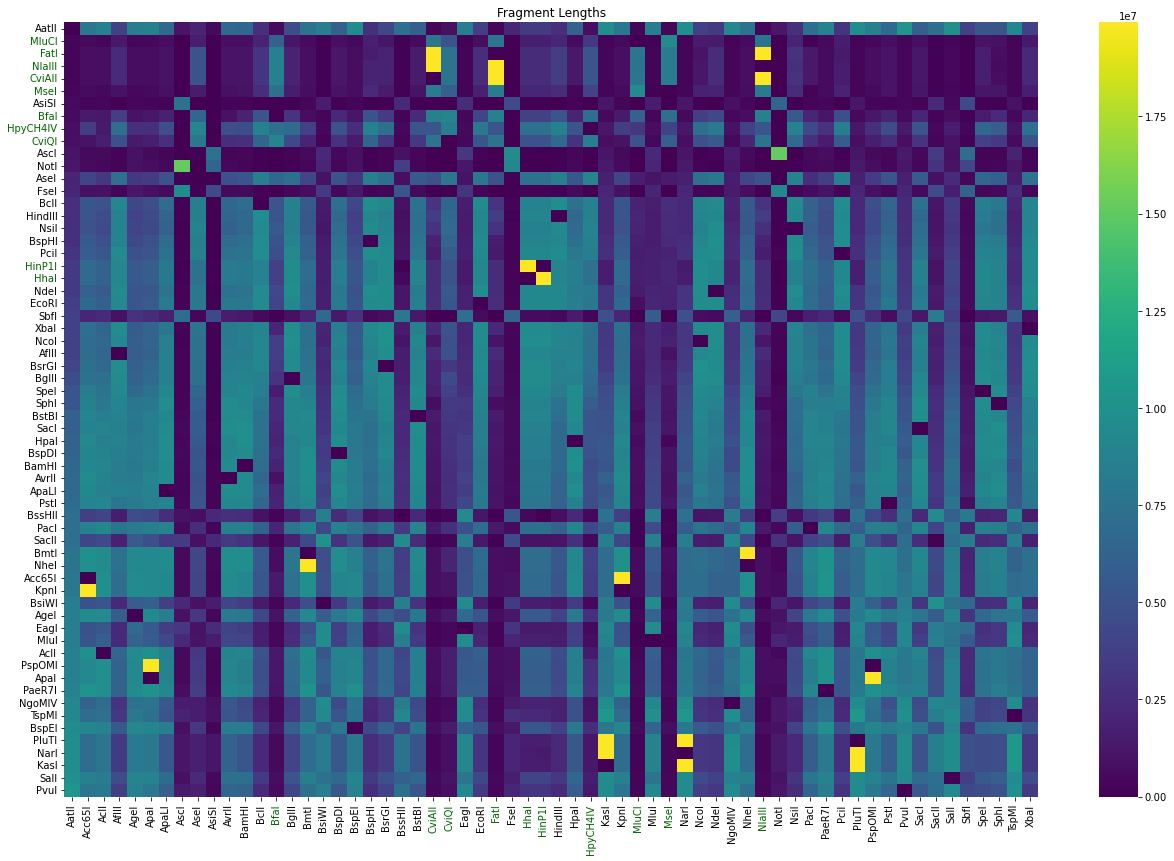

In [366]:
# sort resMatLengths by column

sort_resMatLengths = resMatLengths.sort_values(by=list(resMatLengths.columns))

heatmap_(sort_resMatLengths)

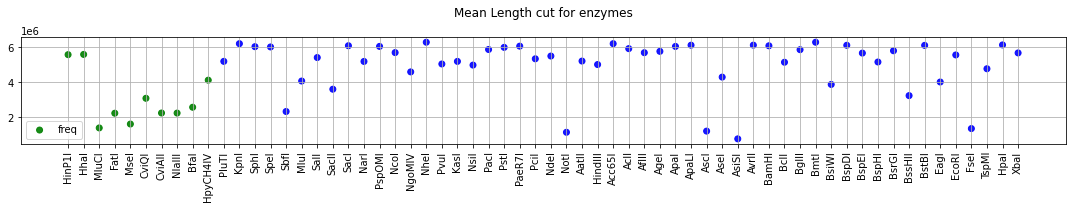

In [463]:
# scatter for mean lengths

pl.figure(figsize=(15,3))
color_mapping = {'freq':"green","rare":"blue"}
colors = [color_mapping[cut] for cut in resMeanLengths["frequent"]]
pl.scatter(x=resMeanLengths.index,y=resMeanLengths["MeanLength"],c=colors, label='freq', alpha=0.9)
pl.grid(True)
pl.title("Mean Length cut for enzymes\n")
pl.xticks(rotation=90)
pl.legend()
pl.tight_layout()

pl.savefig("/home/loukas/Documents/bioinformatics/scatterLengths.pdf",format="pdf",dpi=600)
pl.show()


We observe that frequent enzymes have low mean length whereas rare enzymes have high, which is expected. In contrast, two frequent enzymes seems to sut the chromosome in rather large fragments (HinP1I, HhaI) and three rare enzymes in small fragments (AsiSI, AscI, FseI)

In [281]:
sort_resMatLengths


,HinP1I,HhaI,MluCI,FatI,MseI,CviQI,CviAII,NlaIII,BfaI,HpyCH4IV,...,KasI,NsiI,PacI,PstI,PaeR7I,HpaI,NdeI,NotI,HindIII,XbaI
HinP1I,0,24223853,2079441,2857832,2648366,6142466,2857832,2847937,4694136,8749466,...,1763959,10555379,9185886,9440681,7729299,10215422,11238018,132181,10947874,11480323
AscI,40,45048,7617,8422,7049,20083,8422,8422,13043,39733,...,1500528,91338,226498,348639,410917,285621,135783,12510223,103026,99895
BssHII,584,576086,138385,113456,173075,337898,113456,113456,250805,480246,...,9466997,1044909,3982528,3403248,4799844,2973876,1684536,4757302,1106212,1718042
AsiSI,64602,64602,5523,6838,9212,13102,6838,6838,14942,27722,...,1456294,67605,257679,198987,629993,251468,73552,8679505,70136,227985
NotI,132181,132181,9908,12494,16016,26447,12494,12494,27519,43403,...,2222466,123692,383321,503210,617899,435210,218023,0,177809,294179
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
EcoRI,11409361,11409361,711238,2880056,2002108,6331767,2880056,2877219,4826425,9058280,...,3832677,10990598,9309083,9707147,7938778,10549987,11823427,242495,11078518,11655414
BsrGI,11422857,11422857,1313073,2355662,1722965,3845716,2355662,2361161,4212631,8561398,...,4280760,10569500,9838431,10260354,8483263,10839571,11445522,225074,10650902,11746045
XbaI,11480323,11480321,1582854,2834169,1971619,6149062,2834169,2834169,2710711,8882261,...,4257560,10979460,9647145,9927512,8242504,10456962,11864346,294179,10976321,0
NcoI,11575075,11575077,1692469,1236486,2181520,5707357,1434872,1434872,4328074,8600193,...,3968845,10838023,9801482,10010294,8227874,10654609,11659717,244392,10962638,11921748


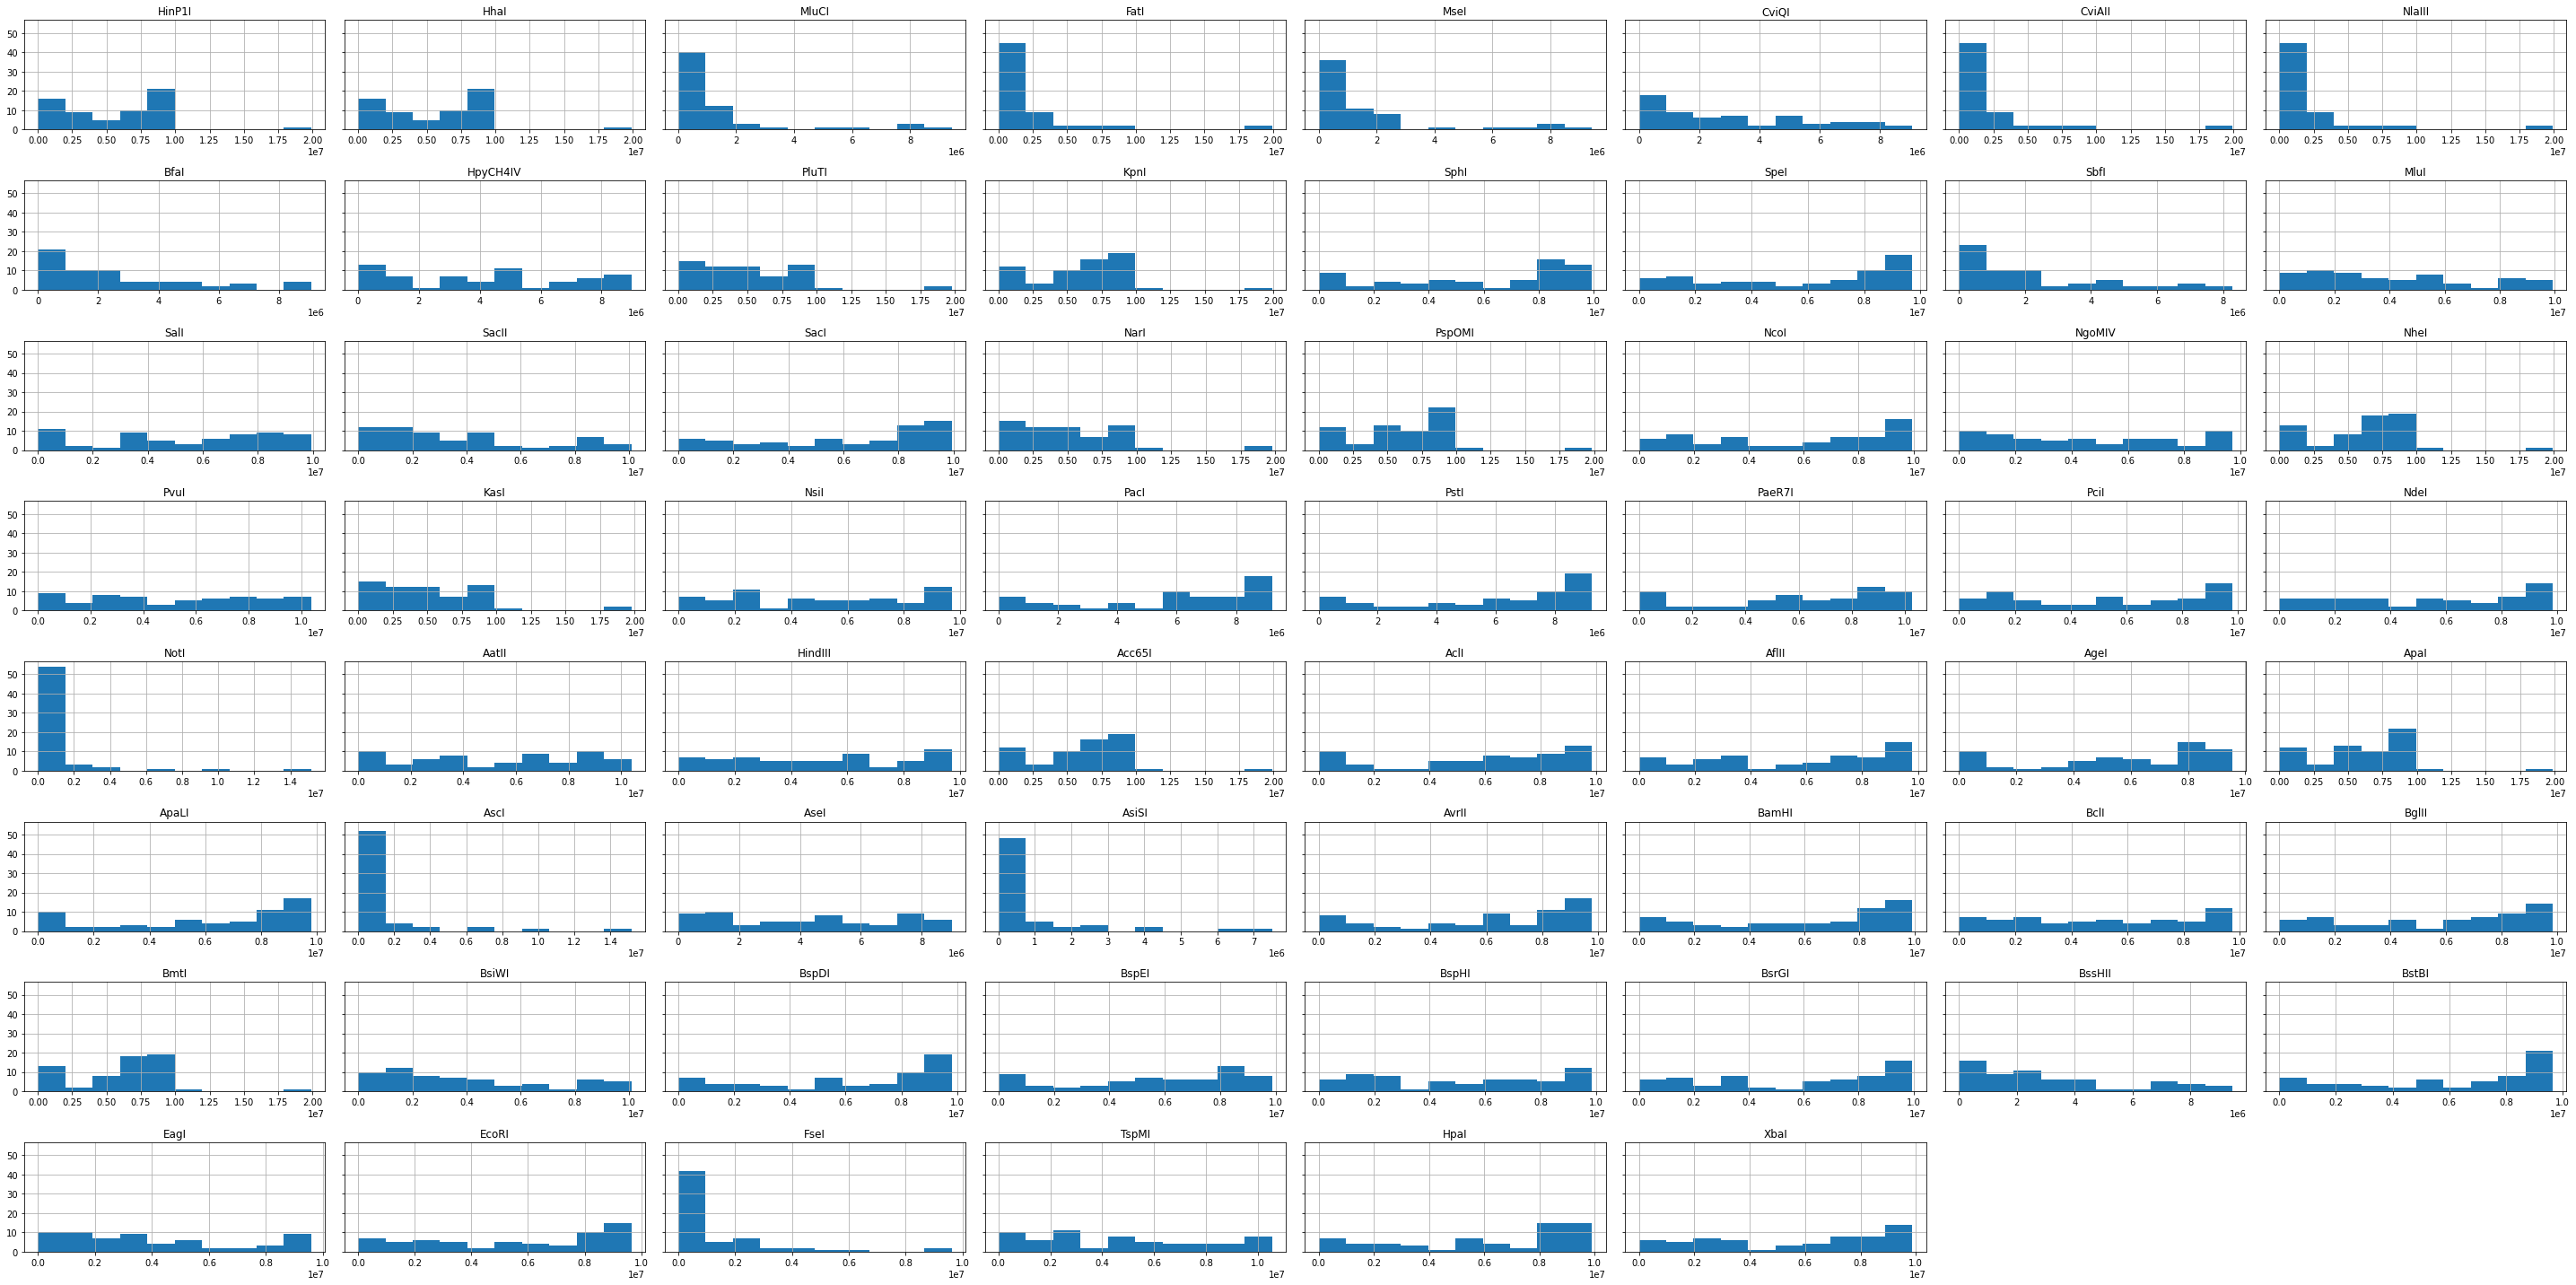

In [464]:
resMatLengths.hist(bins=10, grid=True,sharey=True,figsize=(40,20))
pl.tight_layout()
pl.savefig("/home/loukas/Documents/bioinformatics/hist_all.pdf",format="pdf",dpi=1600)

pl.show()

In [163]:
#enzymes with much small cut lengths
print(renz.get(NotI).site)
print(renz.get(AsiSI).site)
print(renz.get(NotI).site)


GCGGCCGC
GCGATCGC
GCGGCCGC


In [161]:
#enzymes with large cut lengths
print(renz.get(BamHI).site)

GGATCC


In [170]:
# Find cases without a conflict
for enzyme1 in frequent:
    for enzyme2 in rare:
        if enzyme1.site in enzyme2.site:
            resMatConf.loc[str(enzyme1), str(enzyme2)] = 1
        else:
            resMatConf.loc[str(enzyme1), str(enzyme2)] = 0
        

resMatConf

,AatII,Acc65I,AclI,AflII,AgeI,ApaI,ApaLI,AscI,AseI,AsiSI,...,PstI,PvuI,SacI,SacII,SalI,SbfI,SpeI,SphI,TspMI,XbaI
BfaI,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
CviAII,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
CviQI,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
FatI,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
HhaI,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
HinP1I,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
HpyCH4IV,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
MluCI,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
MseI,0,0,0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
NlaIII,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
